
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain synthetic waves and water level timeseries under a climate change scenario (future TCs occurrence probability)

inputs required: 
  * Historical DWTs (for plotting)
  * Historical wave families (for plotting)
  * Synthetic DWTs 
  * Probability of TCs under climate change
  * Historical intradaily hydrograph parameters  
  * TCs waves
  * Fitted multivariate extreme model for the waves associated to each DWT

  
in this notebook:
  * Generate synthetic time series of wave conditions     

In the case of **waves associated to a TC event**, the associated simulated waves from WWIII simulation that have been reconstructed in notebook 07 are use whenever the simulated TC enters the 4 degrees radio. The probability of entering the 4 degree radio (from the 14 degree radio) is modified according to future changes under a climate change scenario


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, Aggregate_WavesFamilies

from teslakit.plotting.outputs import Plot_FitSim_Histograms
from teslakit.plotting.extremes import Plot_FitSim_AnnualMax, Plot_FitSim_GevFit, Plot_Fit_QQ

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.climate_change import Plot_RCP_ocurrence



## Database and Site parameters

In [3]:
# --------------------------------------
# Teslakit database

p_data = r'/media/administrador/HD/Dropbox/Guam/teslakit/data'
# p_data=r'/Users/laurac/Dropbox/Guam/teslakit/data'

# offshore
db = Database(p_data)
db.SetSite('GUAM')

# climate change - S4
db_S4 = Database(p_data)
db_S4.SetSite('GUAM_CC_S4')

# climate emulator simulation modified path
p_S4_CE_sims = op.join(db_S4.paths.site.EXTREMES.climate_emulator, 'Simulations')


In [19]:
# --------------------------------------
# Load data for climate emulator simulation climate change: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim() # DWTs climate change

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

# --------------------------------------
# Load climate change data

lon_rcp, lat_rcp, RCP85ratioHIST_occurrence = db.Load_RCP85()


In [20]:
# solve first 10 DWTs simulations

DWTs_sim = DWTs_sim.isel(n_sim=slice(0, 10))
print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 365244)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 3000-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...
Attributes:
    source:   teslakit_v0.9.1


## Obtain future TCs occurence probability at the site

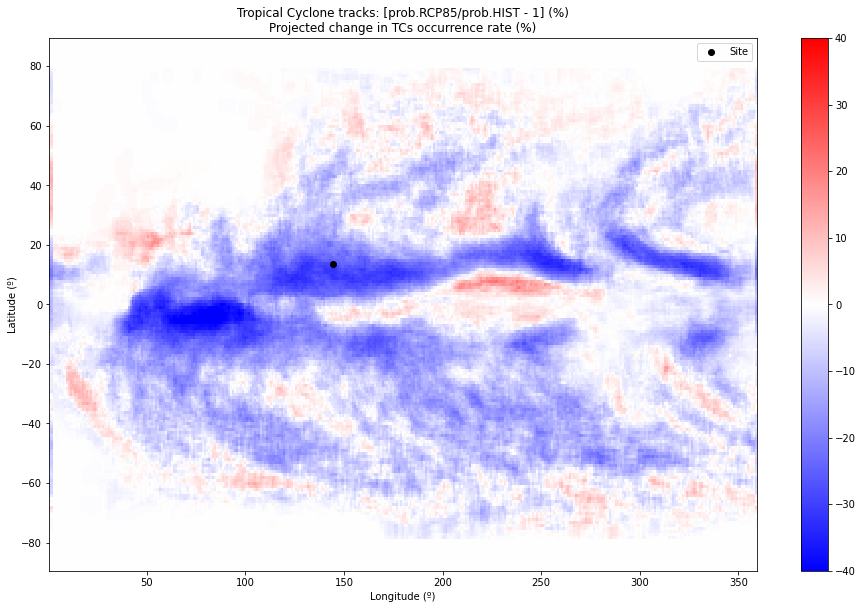

In [22]:
# Guam coordinates
lon_p = 144.75
lat_p = 13.44

# find closest point at RCP data
lon_g, lat_g = np.meshgrid(lon_rcp, lat_rcp)
dif = np.sqrt((lon_g - lon_p)**2 + (lat_g - lat_p)**2)
min_ind = np.where(dif == np.min(dif))
ix_lon, ix_lat = min_ind[0], min_ind[1]

# TCs ocurrence probability at site
TCs_occurrence_prob = RCP85ratioHIST_occurrence[ix_lon, ix_lat]

# Plot global map and location of Site
Plot_RCP_ocurrence(lon_g, lat_g, RCP85ratioHIST_occurrence, ix_lon, ix_lat);

#--------------------------------------
# Modify future probability of a TC affecting the site (modify probability of TC in r1, entering r2)

pchange_TCs +=  pchange_TCs * TCs_occurrence_prob/100.0


## Climate Emulator - Simulation

In [23]:
# --------------------------------------
# Climate Emulator extremes model fitting

# Load Climate Emulator
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

# set a new path for S4 simulations
CE.Set_Simulation_Folder(p_S4_CE_sims, copy_WAVES_noTCs = True)  # waves (no TCs) already simulated


# optional: list variables to override distribution to empirical
# CE.sim_icdf_empirical_override = ['sea_Hs_5',
#                                   'sea_Hs_6',
#                                   'sea_Hs_30',
#                                   'sea_Hs_31'
#                                   'sea_Hs_36',
#                                   'swell_1_Hs_5','swell_1_Tp_5',
#                                   'swell_1_Hs_6',
#                                   'swell_1_Hs_12',
#                                   'swell_1_Hs_20',
#                                   'swell_1_Hs_30','swell_1_Tp_30',
#                                   'swell_1_Hs_31','swell_1_Tp_31',
#                                   'swell_1_Hs_32','swell_1_Tp_32']
# set simulated waves min-max filter


CE.sim_waves_filter.update({
    'hs': (0, 12),
    'tp': (2, 25),
    'ws': (0, 0.06),
})

In [25]:
l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])

In [30]:
# --------------------------------------
#  Climate Emulator simulation

# each DWT series will generate a different set of waves
for n in DWTs_sim.n_sim:
    print('- Sim: {0} -'.format(int(n)+1))
    
    # Select DWTs simulation
    DWTs = DWTs_sim.sel(n_sim=n)
    
    # Load previously simulated waves (no TCs)
    WVS_sim, _, _ = CE.LoadSim(n_sim=int(n))
    
    # Simulate TCs and update simulated waves
    TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs, WVS_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT, extra_vars_update=['wind_speed', 'wind_dir'])

    # store simulation data
    CE.SaveSim(WVS_sim, TCs_sim, WVS_upd, int(n))
    

- Sim: 1 -


C.E: Sim. TCs  : 100%|██████████| 123394/123394 [00:04<00:00, 30815.93it/s]


- Sim: 2 -


C.E: Sim. TCs  : 100%|██████████| 123342/123342 [00:04<00:00, 30742.36it/s]


- Sim: 3 -


C.E: Sim. TCs  : 100%|██████████| 123279/123279 [00:03<00:00, 31842.53it/s]


- Sim: 4 -


C.E: Sim. TCs  : 100%|██████████| 123099/123099 [00:03<00:00, 31984.31it/s]


- Sim: 5 -


C.E: Sim. TCs  : 100%|██████████| 123336/123336 [00:03<00:00, 31567.37it/s]


- Sim: 6 -


C.E: Sim. TCs  : 100%|██████████| 123532/123532 [00:03<00:00, 32373.74it/s]


- Sim: 7 -


C.E: Sim. TCs  : 100%|██████████| 123387/123387 [00:04<00:00, 30638.39it/s]


- Sim: 8 -


C.E: Sim. TCs  : 100%|██████████| 123869/123869 [00:04<00:00, 30743.17it/s]


- Sim: 9 -


C.E: Sim. TCs  : 100%|██████████| 123825/123825 [00:04<00:00, 30779.89it/s]


- Sim: 10 -


C.E: Sim. TCs  : 100%|██████████| 123982/123982 [00:03<00:00, 32349.85it/s]
